In [10]:
import os
import subprocess
import cv2

def download_youtube_video(url, name, resolution='1080p'):
    output_path = f'{name}.mp4'
    command = [
        'yt-dlp',
        '-f', f'bestvideo[height>={resolution[:-1]}][ext=mp4]/best[ext=mp4]',
        '-o', output_path,
        url
    ]
    try:
        subprocess.run(command, check=True)
        print(f"Downloaded video: {output_path}")
    except subprocess.CalledProcessError as e:
        print(f"An error occurred: {e}")

def extract_frames_from_video(video_path, output_folder, frame_rate=1):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Load the video
    vidcap = cv2.VideoCapture(video_path)
    success, image = vidcap.read()
    count = 0
    fps = vidcap.get(cv2.CAP_PROP_FPS)  # Get frames per second of the video
    print(fps)
    interval = int(fps / frame_rate)  # Calculate the interval between frames to capture
    print(f"Video FPS: {fps}, Extracting every {interval} frame(s).")
    
    while success:
        # Save frame as JPEG file
        cv2.imwrite(os.path.join(output_folder, f"frame{count:04d}.jpg"), image)
        count += interval
        # Move the frame position to the next frame to capture
        vidcap.set(cv2.CAP_PROP_POS_FRAMES, count)
        success, image = vidcap.read()

    vidcap.release()


In [6]:
# test 
download_youtube_video('https://www.youtube.com/watch?v=lqXA4JVvcfU','test/dsg_ace')

Downloaded video: test/dsg_ace.mp4


In [11]:
extract_frames_from_video('test/dsg_ace.mp4','Images', 1)

60.01111960525402
Video FPS: 60.01111960525402, Extracting every 60 frame(s).


In [30]:
from PIL import Image

def extract_map(image_path, output_path, left = 0, upper = 0, map_width = 600, map_height = 600):
    """
    Extracts the top-left map portion of an image and saves it as a new .jpg file.

    Parameters:
    - image_path (str): The file path of the input image.
    - output_path (str): The file path to save the extracted map.
    - map_width (int): The width of the map to be extracted.
    - map_height (int): The height of the map to be extracted.
    """
    # Open the image
    img = Image.open(image_path)
    
    # Define the box to extract (left, upper, right, lower)
    box = (left, upper, map_width, map_height)
    
    # Crop the image to the defined box
    map_img = img.crop(box)
    
    # Save the cropped map as a new image
    map_img.save(output_path, format='JPEG')
    print(f"Map saved to {output_path}")

# Example usage
extract_map('Images\\frame0060.jpg', 'Processed_Images\\frame0060.jpg', 
            left = 50, 
            upper = 25, 
            map_width = 550, 
            map_height = 550)


Map saved to Processed_Images\frame0060.jpg


In [31]:
def process_images(input_folder, output_folder):
    """
    Processes all images in a folder, extracts the top-left map portion, and saves it in another folder.

    Parameters:
    - input_folder (str): Path to the folder containing the input images.
    - output_folder (str): Path to the folder where processed images will be saved.
    """
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate over all files in the input folder
    for filename in os.listdir(input_folder):
        # Check if the file is a .jpg image
        if filename.endswith('.jpg'):
            input_image_path = os.path.join(input_folder, filename)
            output_image_path = os.path.join(output_folder, filename)
            
            # for now we are going to hardcode the values
            extract_map(input_image_path,output_image_path,
                        left = 50, 
                        upper = 25, 
                        map_width = 550, 
                        map_height = 550)

In [ ]:
process_images('Images','Processed_Images')

# what remain to do is to : 
## - scrap the youtube links for each match if it exist in vlr.gg
## - Seek at how to make sure to have : link in input and a heat map in output ! 
## - Once dataset is created. The question is : do we need a background of the map and detect player's position through time
## One background for each map in the pull rotation ==> the position in these maps

In [33]:
# !pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="xEb6a3dXc9T0RuJ5Qnox")
project = rf.workspace("gentelmatesheatmap").project("valorant-heat-map")
version = project.version(4)
dataset = version.download("yolov4pytorch")
                

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Valorant-Heat-Map-4 in yolov4pytorch:: 100%|██████████| 462/462 [00:00<00:00, 1357.23it/s]


In [49]:
%cd ..

c:\Users\marius.reymauzaize\Desktop\Project\M8_Valorant\heatMap


In [53]:
import os

def list_files_in_folder_and_write_to_file(folder_path, output_file):
    """
    Lists all files in the specified folder and writes the list to an output file.

    Parameters:
    - folder_path (str): Path to the folder to list files from.
    - output_file (str): The file where the list of files will be written.
    """
    try:
        # List all files in the folder
        files = os.listdir(folder_path)
        
        # Filter to include only files (ignore directories)
        file_list = [f for f in files if os.path.isfile(os.path.join(folder_path, f))]

        # Write the file list to the output file
        with open(output_file, 'w') as f:
            for file_name in file_list:
                if '.jpg' in file_name:
                    f.write(f"data/custom/images/{file_name}\n")

        print(f"List of files has been written to {output_file}")

    except FileNotFoundError:
        print(f"Folder {folder_path} not found.")
        
# Example usage
folder_path = 'Valorant-Heat-Map-4\\valid'  # Specify the folder path
output_file = 'valid.txt'  # Specify the output file path
list_files_in_folder_and_write_to_file(folder_path, output_file)

List of files has been written to valid.txt


In [1]:
from roboflow import Roboflow
rf = Roboflow(api_key="xEb6a3dXc9T0RuJ5Qnox")
project = rf.workspace().project("valorant-heat-map")
model = project.version(3).model

# infer on a local image
# print(model.predict("Processed_Images\\frame0060.jpg", confidence=40, overlap=30).json())

# visualize your prediction
model.predict("Processed_Images\\frame0060.jpg", confidence=40, overlap=30).save("prediction.jpg")

# infer on an image hosted elsewhere
# print(model.predict("URL_OF_YOUR_IMAGE", hosted=True, confidence=40, overlap=30).json())

loading Roboflow workspace...
loading Roboflow project...


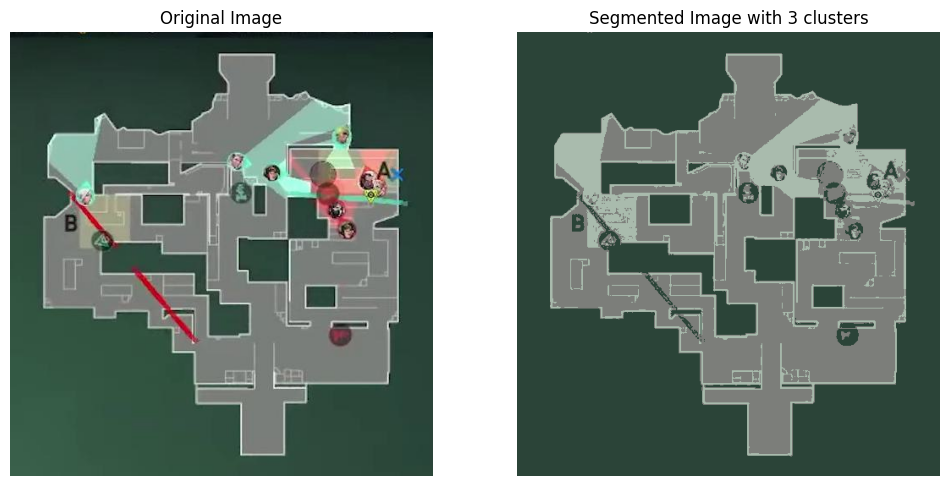

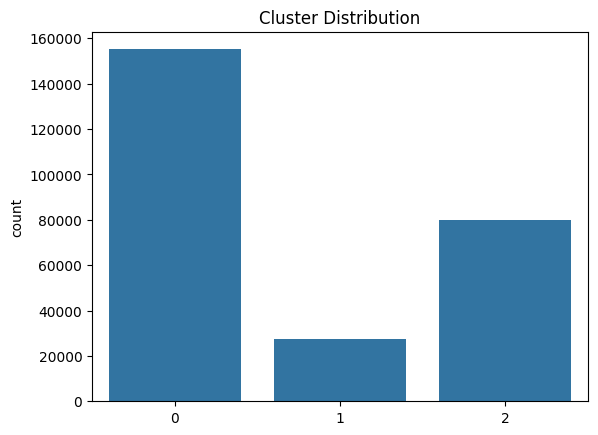

In [40]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns

# Load the image
image_path = 'Processed_Images\\frame1020.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Reshape the image to a 2D array of pixels
pixels = image.reshape(-1, 3)

# Perform k-means clustering to cluster pixels by color
k = 3  # Number of clusters
kmeans = KMeans(n_clusters=k)
kmeans.fit(pixels)

# Replace each pixel's color with its corresponding cluster's centroid color
segmented_image = kmeans.cluster_centers_[kmeans.labels_]
segmented_image = segmented_image.reshape(image.shape)
segmented_image = segmented_image.astype(np.uint8)

# Visualize the original and segmented images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(segmented_image)
ax[1].set_title(f"Segmented Image with {k} clusters")
ax[1].axis("off")

plt.show()

# Create a seaborn plot of cluster distribution
sns.countplot(x=kmeans.labels_)
plt.title("Cluster Distribution")
plt.show()

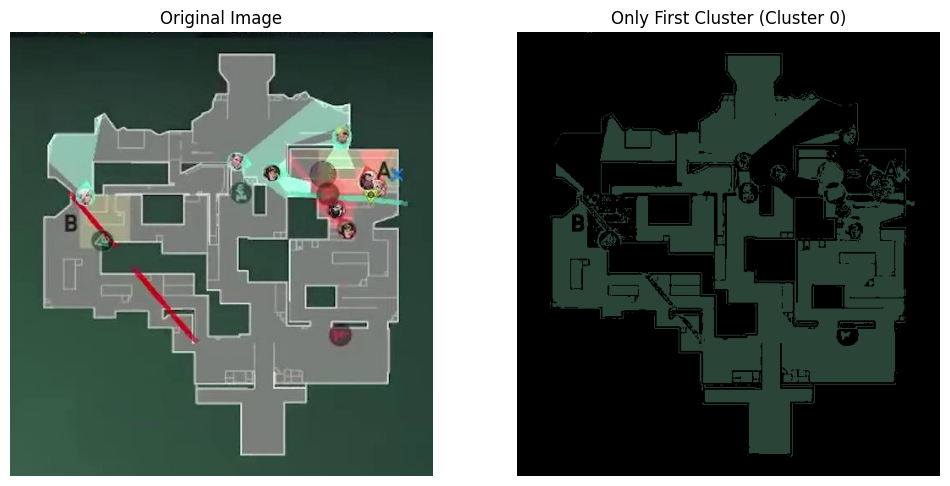

In [43]:
# Create a mask where only the first cluster is visible
first_cluster_mask = (kmeans.labels_ == 2)

# Set all other pixels to black
only_first_cluster = np.zeros_like(pixels)
only_first_cluster[first_cluster_mask] = kmeans.cluster_centers_[0]

# Reshape to the original image shape
only_first_cluster_image = only_first_cluster.reshape(image.shape).astype(np.uint8)

# Visualize the original and the first cluster image
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(only_first_cluster_image)
ax[1].set_title("Only First Cluster (Cluster 0)")
ax[1].axis("off")

plt.show()

ORB (Oriented FAST and Rotated BRIEF)

In [39]:
import cv2
import numpy as np

def resize_img_to_baseline(baseline, img):

    # Step 1: Preprocessing
    # Resize the blurred image to match the baseline image size if necessary
    baseline_height, baseline_width = baseline.shape[:2]

    # Resize the blurred image to fit the baseline's width while maintaining aspect ratio
    blurred_image_resized = cv2.resize(img, (baseline_width, int(img.shape[0] * (baseline_width / img.shape[1]))))

    # If the resized blurred image height is larger than the baseline, adjust the height as well
    if blurred_image_resized.shape[0] > baseline_height:
        blurred_image_resized = cv2.resize(blurred_image_resized, (baseline_width, baseline_height))
    
    return blurred_image_resized
    
def compute_resemblance(baseline, img, resizing=True):
    # Load images
    img1 = cv2.imread(baseline, 0)  # Query image (known map)
    img2 = cv2.imread(img, 0)  # Test image (image you uploaded)

    if resizing:
        img2_resized = resize_img_to_baseline(img1,img2)
    else:
        img2_resized = img2

    # Initiate ORB detector
    orb = cv2.ORB_create()

    # Find keypoints and descriptors with ORB
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2_resized, None)

    # Create BFMatcher object with Hamming distance
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match descriptors
    matches = bf.match(des1, des2)

    # Sort matches by distance (optional, but helps if you want the best matches)
    matches = sorted(matches, key=lambda x: x.distance)

    # Get number of matches and similarity score
    num_matches = len(matches)  # Total number of matches
    total_keypoints = min(len(kp1), len(kp2))  # Take the minimum number of keypoints from both images

    # Ratio of matches to keypoints
    if total_keypoints > 0:
        similarity_ratio = num_matches / total_keypoints
    else:
        similarity_ratio = 0  # Avoid division by zero

    # Display results
    print(f"Total Matches: {num_matches}")
    print(f"Total Keypoints in Query Image: {len(kp1)}")
    print(f"Total Keypoints in Test Image: {len(kp2)}")
    print(f"Similarity Ratio: {similarity_ratio:.2f}")

    return num_matches, similarity_ratio, base_map_path

def compute_adjusted_resemblance(baseline, img, resizing=True):

    # Load the images
    img1 = cv2.imread(baseline, 0)  # Query image (known map)
    img2 = cv2.imread(img, 0)  # Test image (image you uploaded)

    if resizing:
        img2_resized = resize_img_to_baseline(img1,img2)
    else:
        img2_resized = img2

    # Initiate ORB detector
    orb = cv2.ORB_create()

    # Find keypoints and descriptors with ORB
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2_resized, None)

    # Create BFMatcher object (for KNN matcher)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING)

    # Find the top 2 matches for each keypoint (KNN matching)
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply ratio test to find good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    # Number of good matches
    num_good_matches = len(good_matches)

    # Additional scoring metrics
    # Average distance of good matches
    if num_good_matches > 0:
        avg_distance = np.mean([m.distance for m in good_matches])
    else:
        avg_distance = float('inf')  # Handle case with no good matches

    # Similarity score based on good matches and average distance
    similarity_score = num_good_matches / (len(kp1) + len(kp2))  # Normalized score
    adjusted_score = similarity_score / (1 + avg_distance / 100)  # Adjust based on distance (tune the factor)

    # Display results
    print(f"Total Keypoints in Query Image: {len(kp1)}")
    print(f"Total Keypoints in Test Image: {len(kp2)}")
    print(f"Good Matches: {num_good_matches}")
    print(f"Average Distance of Good Matches: {avg_distance:.2f}")
    print(f"Similarity Score: {similarity_score:.4f}")
    print(f"Adjusted Similarity Score: {adjusted_score:.4f}")

    return adjusted_score, baseline

def compute_ransac_homographic_resemblance(baseline, img, resizing=True):

    # Load the images
    baseline_image = cv2.imread(baseline, cv2.IMREAD_COLOR)
    blurred_image = cv2.imread(img, cv2.IMREAD_COLOR)

    if resizing:
        # add preprocessing
        blurred_image_resized = resize_img_to_baseline(baseline_image,blurred_image)
    else:
        blurred_image_resized = blurred_image

    # Step 2: Feature Detection
    orb = cv2.ORB_create()
    kp_baseline, des_baseline = orb.detectAndCompute(baseline_image, None)
    kp_blurred, des_blurred = orb.detectAndCompute(blurred_image_resized, None)

    # Step 3: Feature Matching
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)  # Cross-check is false to use KNN
    matches = bf.knnMatch(des_baseline, des_blurred, k=2)

    # Step 4: Ratio test to filter good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:  # Lowe's ratio test
            good_matches.append(m)

    # Step 5: Geometric verification using RANSAC to find the homography
    if len(good_matches) >= 4:  # Need at least 4 matches to compute homography
        src_pts = np.float32([kp_baseline[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp_blurred[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        # Compute the homography
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        # Step 6: Determine if the images match
        matches_mask = mask.ravel().tolist()
        num_good_matches = sum(matches_mask)
        similarity_score = num_good_matches / len(good_matches)  # Calculate a similarity score

        print(f"Total Good Matches: {num_good_matches}")
        print(f"Total Matches: {len(good_matches)}")
        print(f"Similarity Score: {similarity_score:.2f}")
    
    return similarity_score, baseline

def find_map(baseline_folder, study_img, resizing = True, compute_type='Default'):
    """ Find the map under study based on resemblance
        compute_type can take 3 values : 'Default', 'Adjusted' or 'Homographic' """
    baseline_img_paths = []

    # Loop through all the files in the baseline folder
    for filename in os.listdir(baseline_folder):
        if filename.endswith(".jpg"):
            # Construct the full file path
            file_path = os.path.join(baseline_folder, filename)

            baseline_img_paths.append(file_path)

    if compute_type == 'Default':
        # compute resemblance and store each scores
        return [compute_resemblance(base_map, study_img, resizing) for base_map in baseline_img_paths]
    
    if compute_type == 'Adjusted':
        # compute resemblance and store each scores
        return [compute_adjusted_resemblance(base_map, study_img, resizing) for base_map in baseline_img_paths]
    
    if compute_type == 'Homographic':
        # compute resemblance and store each scores
        return [compute_ransac_homographic_resemblance(base_map, study_img, resizing) for base_map in baseline_img_paths]

def find_sample_of_maps(baseline_folder, study_folder, sample_size = 1):
    """ Need to go through a sample of image and compute a resemblance method than average it all to have with the sample size the average
        Need to use all the the define function upward"""
    return 0 
# find_map("Base_map","Processed_Images\\frame1020.jpg")
